In [12]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_processing import load_features
from src.models import load_model

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [14]:
# Try custom-extracted first, then pre-extracted
try:
    features_path = "../data/processed/features.csv"
    X, y = load_features(features_path)
except FileNotFoundError:
    features_path = "../data/raw/Data/features_30_sec.csv"
    X, y = load_features(features_path)

df = pd.concat([X, y], axis=1)

print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Show genre distribution
print("\nGenre distribution:")
genre_counts = y.value_counts()
print(genre_counts)

Loading features from: ../data/processed/features.csv
Using 'genre' column for targets
Loaded 999 samples with 75 features
Genres: ['pop' 'metal' 'disco' 'blues' 'reggae' 'classical' 'rock' 'hiphop'
 'country' 'jazz']
Dataset shape: (999, 76)
Features: 75
Samples: 999

Genre distribution:
genre
pop          100
metal        100
disco        100
blues        100
reggae       100
classical    100
rock         100
hiphop       100
country      100
jazz          99
Name: count, dtype: int64


Feature Statistics:
       mfcc_0_mean  mfcc_0_std  mfcc_1_mean  mfcc_1_std  mfcc_2_mean  \
count   999.000000  999.000000   999.000000  999.000000   999.000000   
mean   -144.529693   57.643114    99.529891   25.472658    -8.930675   
std     100.274375   20.655117    31.334739    7.599018    21.702666   
min    -552.106323   13.212185    -1.539154    9.652890   -89.896149   
25%    -200.849762   42.999990    76.792130   19.955133   -24.230801   
50%    -120.324814   56.021267    98.399033   24.628401   -10.732934   
75%     -73.791946   70.461452   119.732929   29.746087     5.539077   
max      42.112865  168.089783   193.094482   63.492550    56.636234   

       mfcc_2_std  mfcc_3_mean  mfcc_3_std  mfcc_4_mean  mfcc_4_std  ...  \
count  999.000000   999.000000  999.000000   999.000000  999.000000  ...   
mean    20.773784    36.307606   14.346683    -1.154265   12.723238  ...   
std      6.061439    16.668253    3.820576    12.227953    3.538159  ...   
min      5.964447   -18.786

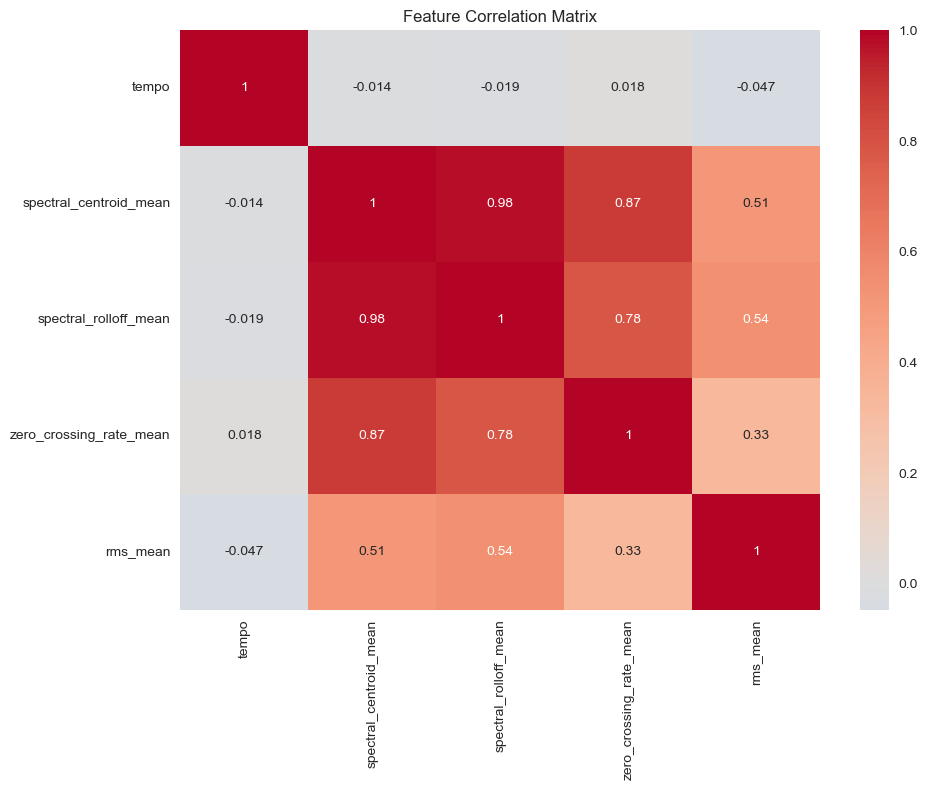

In [15]:
if df is not None:
    # Feature statistics
    print("Feature Statistics:")
    print(X.describe())
    
    # Correlation matrix for key features
    key_features = ['tempo', 'spectral_centroid_mean', 'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean']
    
    available_features = [f for f in key_features if f in X.columns]
    
    if available_features:
        plt.figure(figsize=(10, 8))
        correlation_matrix = X[available_features].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

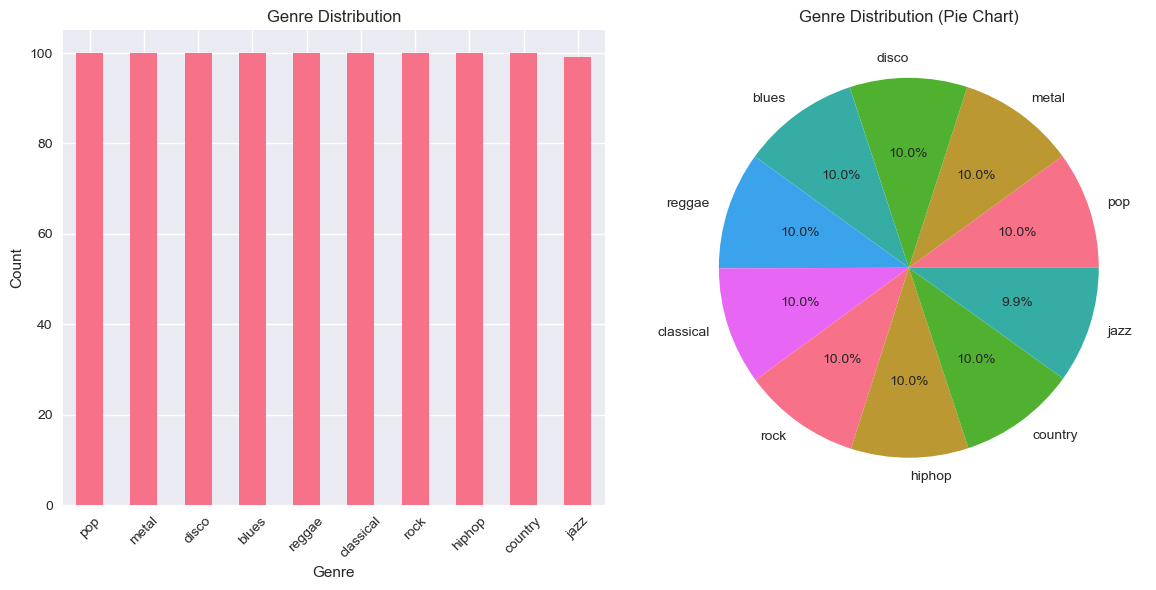

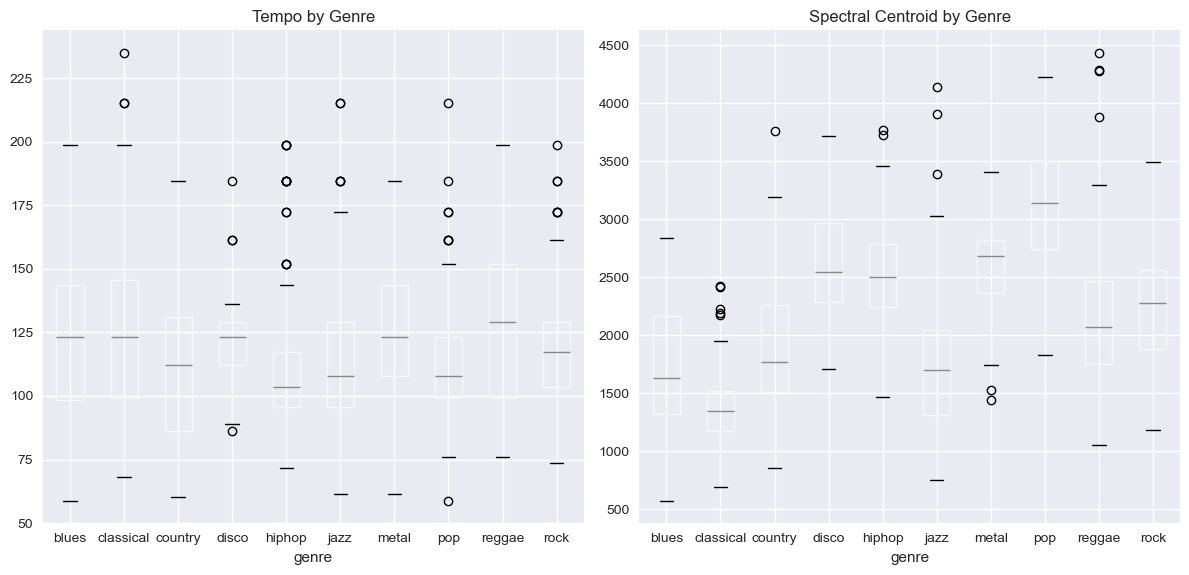

In [17]:
if df is not None:
    # Genre distribution plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    genre_counts.plot(kind='bar')
    plt.title('Genre Distribution')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%')
    plt.title('Genre Distribution (Pie Chart)')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze tempo by genre
    label_col = 'label' if 'label' in df.columns else 'genre'
    if 'tempo' in df.columns:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        df.boxplot(column='tempo', by=label_col, ax=plt.gca())
        plt.title('Tempo by Genre')
        plt.suptitle('')
        
        plt.subplot(1, 2, 2)
        if 'spectral_centroid_mean' in df.columns:
            df.boxplot(column='spectral_centroid_mean', by=label_col, ax=plt.gca())
            plt.title('Spectral Centroid by Genre')
            plt.suptitle('')
        
        plt.tight_layout()
        plt.show()

In [18]:
# Load trained model
model_path = "../models/random_forest_model.pkl"

try:
    model = load_model(model_path)
    print("Model loaded successfully!")
    print(f"Model type: {model.model_name}")
    
    # Example prediction (using a sample from the data)
    if df is not None:
        sample_features = X.iloc[0:1].values
        
        # Scale features using the model's scaler
        sample_features_scaled = model.scaler.transform(sample_features)
        
        # Make prediction
        y_pred_num = model.model.predict(sample_features_scaled)
        prediction = model.label_encoder.inverse_transform(y_pred_num)[0]
        
        true_label = y.iloc[0]
        
        print(f"\nSample prediction:")
        print(f"True genre: {true_label}")
        print(f"Predicted genre: {prediction}")
        print(f"Correct: {prediction == true_label}")
        
except FileNotFoundError:
    print("Model file not found. Please run training first.")
except Exception as e:
    print(f"Error loading model: {str(e)}")

Model loaded successfully!
Model type: RandomForest

Sample prediction:
True genre: pop
Predicted genre: blues
Correct: False


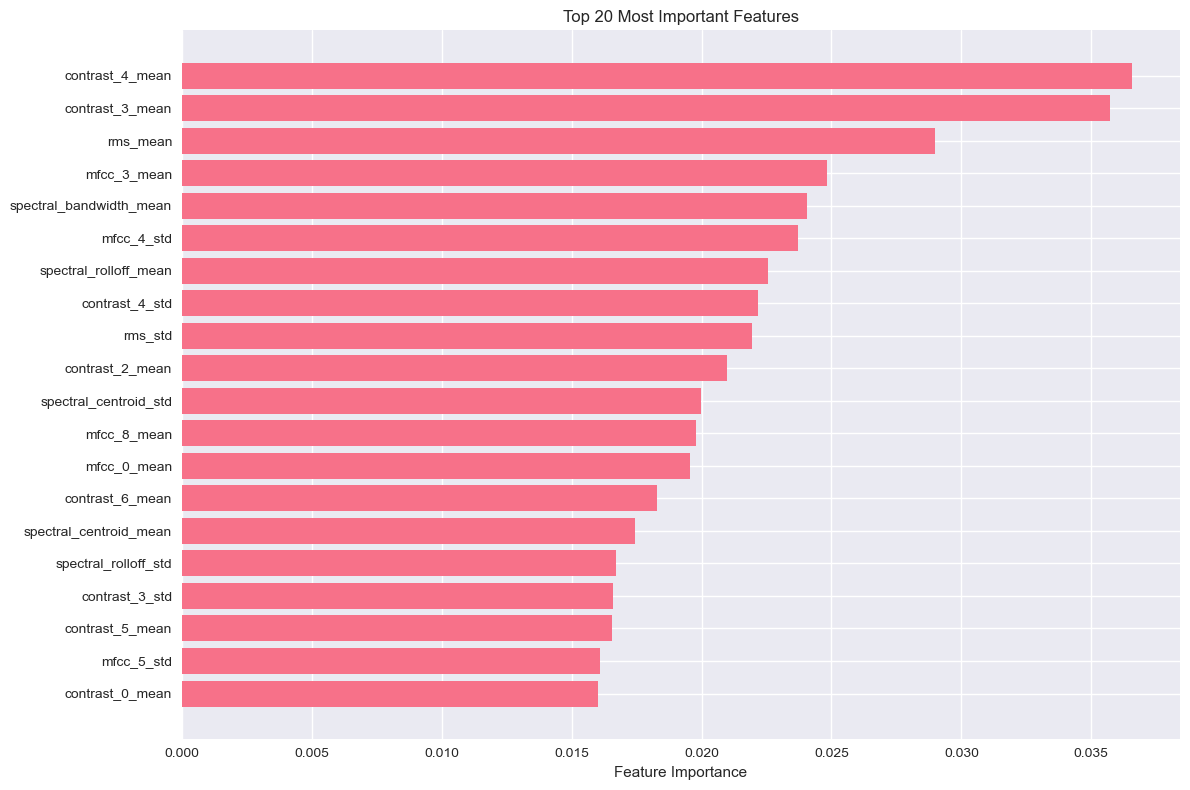


Top 10 Most Important Features:
                    feature  importance
69          contrast_4_mean    0.036587
67          contrast_3_mean    0.035732
59                 rms_mean    0.028978
6               mfcc_3_mean    0.024835
30  spectral_bandwidth_mean    0.024073
9                mfcc_4_std    0.023701
28    spectral_rolloff_mean    0.022540
70           contrast_4_std    0.022158
60                  rms_std    0.021937
65          contrast_2_mean    0.020991


In [19]:
if df is not None:
    # For Random Forest, we can get feature importance
    try:
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import StandardScaler
        
        # Train a simple Random Forest for feature importance
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_scaled, y_train)
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Most Important Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))
        
    except Exception as e:
        print(f"Error analyzing feature importance: {str(e)}")